# Демодуляция. Часть 2.
# Single Sideband Suppressed Carrier 
# (AM-SSB-SC)

## 1. Совместная передача сигналов с однополосной модуляцией

Как упоминалось ранее, главным преимуществом SSB модуляции является уменьшение ширины спектра модулированного сигнала в два раза по сравнению с обычной DSB модуляцией. Это означает, что в той же самой полосе можно одновременно передавать сообщения сразу от двух пользователей. Однако, при этом потребуется внести определенные изменения в думодулятор, чтобы на приемной стороне можно было разделить эти два сообщения.

Для наглядности пусть первый пользователь передает аудиосообщения и использует USB модуляцию. Второй пользователь передает сигнал, состоящий из трех гармонических тонов с помощью LSB модуляции. Оба сообщения переносятся на частоту несущей, равную 60 kHz, с помощью модулятора на основе преобразования Гильберта. 

В файле Audio_Source.wav записано звуковое сообщение с частотой дискретизации 44.1 kHz. Частота несущей будет равна 60 kHz. Чтобы избежать наложения спектров, выберем итоговую частоту дискретизации модулированного сигнала в 5 раз больше частоты аудиосигнала, то есть 5 * 44.1 kHz. Это потребует провести интерполяцию для увеличения частоты дискретизации информационного сообщения.

Гармонические сигналы для второго пользователя также формируются на частоте дискретизации 44.1 kHz, а затем совместно с аудиосообщением переносятся на частоту несущей.
Скрипт, выполняющий формирование совместного модулированного сигнала, представлен ниже: 

<IPython.core.display.Javascript object>


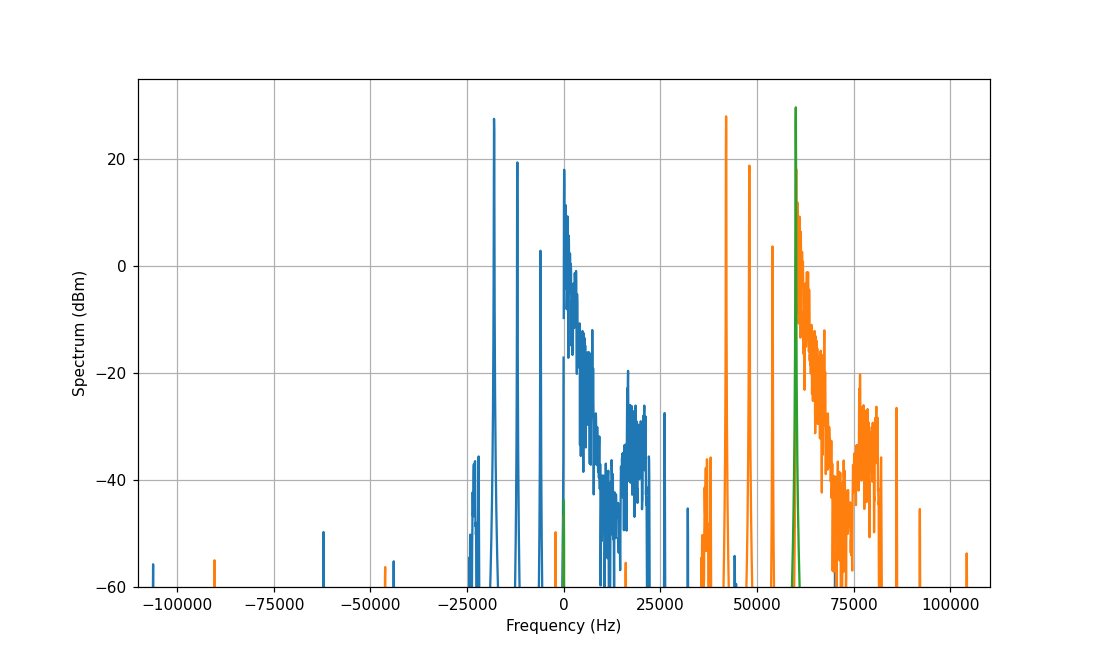

In [1]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly, firls, lfilter, hilbert

audio_frame_size = 1000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 100      # число обрабатываемых пачек данных
rate_ratio = 5          # коэффициент увеличения частоты дискретизации

# открываем файл и получаем частоту дискретизации
audio_file = wave.open('../../wav/Audio_Source.wav')
audio_fs = audio_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
signal_fs = audio_fs * rate_ratio
signal_frame_size = audio_frame_size * rate_ratio

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-60, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

ssb_am_signal_array = np.zeros((frames_number, signal_frame_size), dtype=complex)

t_a = np.linspace(0, audio_frame_size/audio_fs, audio_frame_size) 
t_s = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование сигнала для первого пользователя
    user1_data = audio_file.readframes(audio_frame_size)    # считываем отсчеты
    user1_data = np.frombuffer(user1_data, dtype=np.int16)  # преобразуем тип данных из byte в int16
    user1_data = np.reshape(user1_data, (-1, 2))            # разделяем отсчеты для правого и левого канала
    user1_data = user1_data[:,0] / 2**15                    # нормируем отсчеты к единице
    
    # формирование сигнала для второго пользователя
    user2_data = 0.05* np.cos(2 * np.pi * 6e3 * t_a)
    user2_data += 0.3* np.cos(2 * np.pi * 12e3 * t_a)
    user2_data += 0.8* np.cos(2 * np.pi * 18e3 * t_a)
    
    # формирование аналитических сигналов
    analytic_user1_data = hilbert(user1_data)
    analytic_user2_data = np.conj(hilbert(user2_data)) 
    
    # формирование совместного сигнала
    composed_analytic_data = analytic_user1_data + analytic_user2_data
    
    # увеличиваем частоту дискретизации
    upsampled_data = resample_poly(composed_analytic_data, rate_ratio, 1)
    
    # комплексный несущий сигнал
    # частота несущей: 60 kHz
    carrier = np.exp(1j * 2 * np.pi * 60e3 * t_s)
    
    # однополосная модуляция
    ssb_am_signal = upsampled_data * carrier    
    ssb_am_signal_array[frame,:] = ssb_am_signal

    # построение спектрограмм
    signals = upsampled_data, ssb_am_signal, carrier
    
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=4096) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)

    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t_a = t_a + audio_frame_size/audio_fs
    t_s = t_s + signal_frame_size/signal_fs 



На спектрограмме можно увидеть, что аудиосообщение от первого пользователя находится в верхней половине полосы модулированного сигнала. Три гармонических тона от второго пользователя располагаются в нижней половине спектра. Если в приемном устройстве просто умножить данный сигнал на несущую для переноса спектра на нулевую частоту, то это приведет к наложению спектров пользователей друг на друга. Поэтому демодулятор должен быть изменен, чтобы иметь возможность разделить сообщения пользователей. 

## 2. Демодулятор на основе низкочастотного фильтра

Один из вариантов разделения сообщений основан на методе, похожем на третий метод (third method) SSB модуляции. В дальнейшем будем считать, что выполняется квадратурный прием. Сигнал с помощью умножения на комплексную экспоненту переносится таким образом, чтобы нулевая частота совпала с серединой спектра одного из сообщений. Далее с помощью низкочастотного фильтра одно из сообщений удаляется, и полученный сигнал опять смещается, чтобы точно попасть на 

Схема приемного устройства имеет вид:

<img src="../../images/SSB_SC_Receiver_2_1.png" width=550/>

Ниже представлен скрипт, выполняющий описанные выше преобразования:

<IPython.core.display.Javascript object>


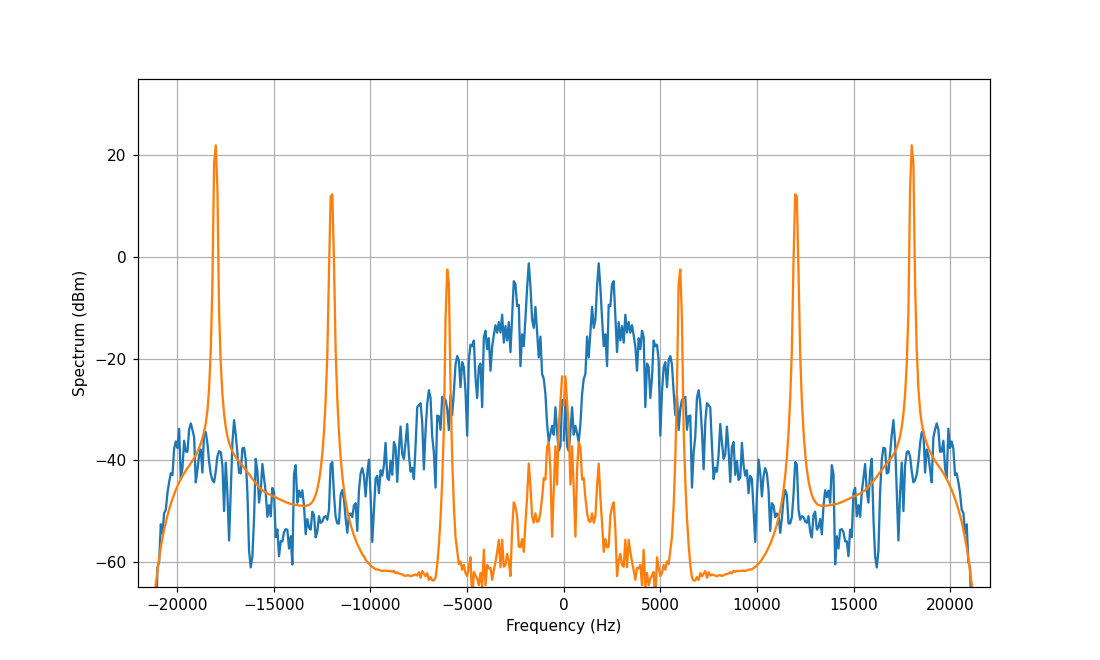

In [2]:
# получение коэффициентов ФНЧ
H = firls(275, (0, 9e3, 10e3, signal_fs/2), (1, 1, 0, 0), fs=signal_fs)

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-audio_fs/2, audio_fs/2)
ax.set_ylim(-65, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(2):
    ax.plot(np.arange(audio_frame_size), np.zeros(audio_frame_size))

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

# внутреннее состояние ФНЧ
FIR1_tap_values = np.zeros(len(H) - 1) 
FIR2_tap_values = np.zeros(len(H) - 1)

for frame in range(frames_number):

    # получение отсчетов сигнала
    ssb_am_signal = ssb_am_signal_array[frame,:]

    # получение несущих
    user1_carrier = np.exp(1j * 2 * np.pi * (60e3 + 11e3) * t)
    user2_carrier = np.exp(1j * 2 * np.pi * (60e3 - 11e3) * t)

    # смещение сигналов по частоте
    user1_mixed_data = ssb_am_signal * np.conj(user1_carrier);
    user2_mixed_data = ssb_am_signal * np.conj(user2_carrier);
    
    # низкочастотная фильтрация
    user1_filtered_data, FIR1_tap_values = lfilter(H, 1.0, user1_mixed_data, zi=FIR1_tap_values)
    user2_filtered_data, FIR2_tap_values = lfilter(H, 1.0, user2_mixed_data, zi=FIR2_tap_values)

    # получения комплексной экспоненты для компенсации сдвига по частоте
    user1_mixer = np.exp(1j * 2 * np.pi *  11e3 * t)
    user2_mixer = np.exp(1j * 2 * np.pi * -11e3 * t)
    
    # компенсация сдвига по частоте
    user1_baseband_data = user1_filtered_data * user1_mixer;
    user2_baseband_data = user2_filtered_data * user2_mixer;
    
    # уменьшение частоты дискретизации
    user1_data = np.real(resample_poly(user1_baseband_data, 1, rate_ratio))
    user2_data = np.real(resample_poly(user2_baseband_data, 1, rate_ratio))
    
    # построение спектрограмм
    signals = user1_data, user2_data
    for i in range(2):
        f, spectrum = welch(signals[i], audio_fs, return_onesided=False, scaling='spectrum', nperseg=512) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

На спектрограмме можно увидеть разделенные сообщения от первого (синий) и второго (оранжевый) пользователя. Из-за того, что низкочастотный фильтр имеет конечное ослабление в полосе подавления, низкочастотные спектранльные компоненты от первого пользователя попадают ко второму. Однако, они ослаблены до уровня -30 dB. В зависимости от решаемой задачи и технических требований этого может быть достаточно, а может быть и нет. Также можно увидеть, что из аудиосообщения удалены низкочастотные составляющие спектра.

## 3. Демодулятор на основе преобразования Гильберта

Другой способ разделения сообщений пользователей заключается в использовании преобразования Гильберта. В дальнейшем будем считать, что выполняется квадратурный прием. Принятый сигнал сразу переносится на нулевую частоту. Далее, используя преобразование Гильберта, можем виделить отдельно спектральные компоненты на положительных и отрицительных частотах. Это приводит к разделению сообщений от пользователей.

Схема приемного устройства имеет вид:

<img src="../../images/SSB_SC_Receiver_2_2.png" width=700/>

Ниже представлен скрипт, выполняющий описанные выше преобразования:

<IPython.core.display.Javascript object>


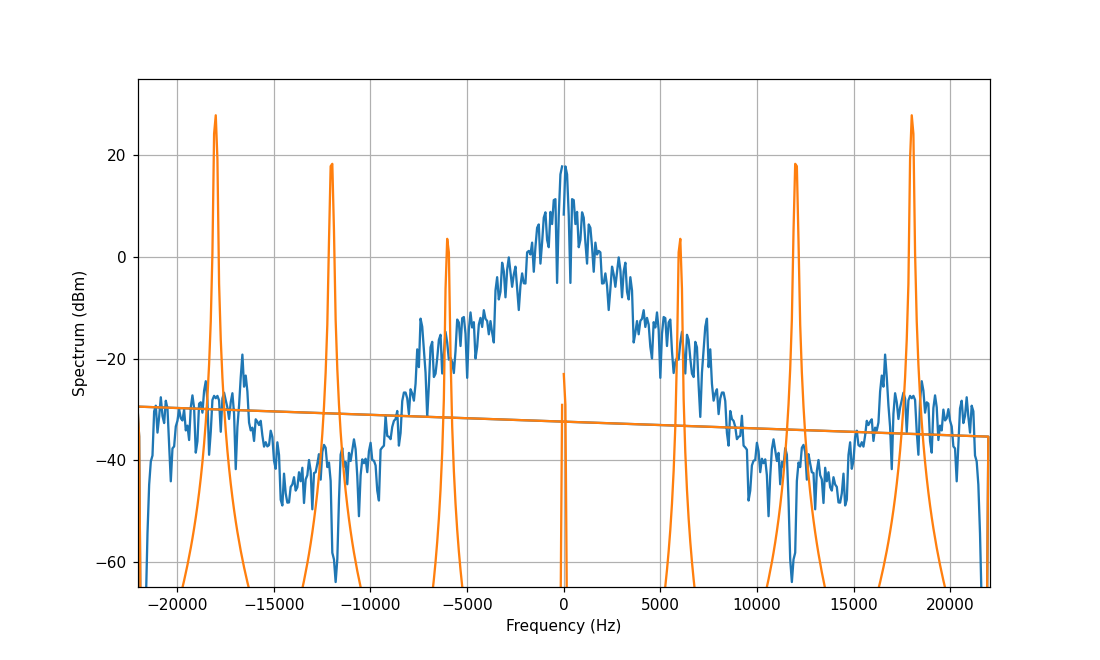

In [2]:
# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-audio_fs/2, audio_fs/2)
ax.set_ylim(-65, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(2):
    ax.plot(np.arange(audio_frame_size), np.zeros(audio_frame_size))

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # получение отсчетов сигнала
    ssb_am_signal = ssb_am_signal_array[frame,:]

    # получение несущей
    carrier = np.exp(1j * 2 * np.pi * 60e3 * t)
    
    # смещение сигнала по частоте
    mixed_data = ssb_am_signal * np.conj(carrier);
    
    # уменьшение частоты дискретизации
    downsampled_data = resample_poly(mixed_data, 1, rate_ratio)
    
    # разделение сигналов с помощью преобразования Гильберта
    # функция hilbert требует на вход действительный 
    # сигнала, поэтому преобразование Гильберта вычисляется отдельно для
    # мнимой и действительной части. Так как эта операция линейная,
    # умножив преобразование от мнимой части на j и сложив с 
    # преобразованием от действительной части, получим 
    # односторонний спектр
    analytic_data_real = hilbert(np.real(downsampled_data))
    analytic_data_imag = hilbert(np.imag(downsampled_data))
    analytic_data = analytic_data_real + 1j * analytic_data_imag
    
    # разделение сообщений
    user1_data = np.real(analytic_data_real + 1j*analytic_data_imag)
    user2_data = np.real(analytic_data_real - 1j*analytic_data_imag)
    
    # построение спектрограмм
    signals = user1_data, user2_data
    for i in range(2):
        f, spectrum = welch(signals[i], audio_fs, return_onesided=False, scaling='spectrum', nperseg=512) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

На спектрограмме можно увидеть разделенные сообщения от первого (синий) и второго (оранжевый) пользователя.

## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR